# Lab: using clustering to find best store locations

Imagine the following situation:<br>
You own a pizza chain, and you collected data about pizza deliveries in a certain neighborhood. The data contains a coordinate of each delivery as a pair *(Latitude, Longitude)*. You do not have any stores in this neighborhood, and driving there each time is too expensive (especially with current gas prices). So you decide to open $K$ new stores in this area. The task is, based on the frequent delivery data, determine the best locations for the new stores.

You need to perform the $K$-means clustering of delivery locations, and otput the best location for $K$ new stores. How would you choose the location of the store within each cluster that minimizes the overall distance between the store and each delivery address? __Explain your idea in a separate cell below.__

The data is 2-dimensional and it is easy to plot it to see if the locations of new stores make sense.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import pandas as pd
import numpy as np

The data is a real data collected by [this person](https://github.com/angelddaz) while they were working as a pizza delivery driver. The file [pizza_delivery_locations.csv](https://drive.google.com/file/d/1tSpqC5sM7DegMil4D9U3DN9exYNATpiA/view?usp=sharing) is a projection of the original data and contains only *(Latitude, Longitude)* of each delivery address. Download the file and update the path below.

In [2]:
data_file = "../datasets/pizza_delivery_locations.csv"

In [3]:
data = pd.read_csv(data_file)
pd_dat = pd.read_csv(data_file)
print(data.columns)
len(data)

# convert dataframe to a 2D numpy array - it is easier to work with it
data = data.to_numpy()

Index(['Latitude', 'Longitude'], dtype='object')


In [77]:
lat_mean = np.mean(pd_dat['Latitude'])
lat_std = np.std(pd_dat['Latitude'])
long_mean = np.mean(pd_dat['Longitude'])
long_std = np.std(pd_dat['Longitude'])

pd_dat['LatitudeCent'] = (pd_dat['Latitude'] - lat_mean) / lat_std
pd_dat['LongitudeCent'] = (pd_dat['Longitude'] - long_mean) / long_std

# Idea:

The main idea here will be to make clusters and place our new locations at the centroids of each cluster. This should minimize the distances across all our locations for each customer. 

## Task 1.

Use $K$-means clustering algorithm to find the best locations for new pizza stores for $K$=2, $K$=3 and $K$=4. The answers should be represented as lists of *(Latitide,Longitude)* tuples for each value of $K$.

You can use the custom code from the k-means demo, or you can use the `sklearn.KMeans` module to perform clustering.

In [6]:
import random
from math import sqrt

def manhattan(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))

    for i in range(dimensions):
        res+=abs(v1[i]-v2[i])

    return res


def euclidean(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))
    for i in range(dimensions):
        res+=pow(abs(v1[i]-v2[i]),2)

    return sqrt(float(res))


def cosine(v1,v2):
    dotproduct=0
    dimensions=min(len(v1),len(v2))

    for i in range(dimensions):
        dotproduct+=v1[i]*v2[i]

    v1len=0
    v2len=0
    for i in range (dimensions):
        v1len+=v1[i]*v1[i]
        v2len+=v2[i]*v2[i]

    v1len=sqrt(v1len)
    v2len=sqrt(v2len)
    
    # we need distance here - 
    # we convert cosine similarity into distance
    return 1.0-(float(dotproduct)/(v1len*v2len))
  

def pearson(v1,v2):
    # Simple sums
    sum1=sum(v1)
    sum2=sum(v2)
  
    # Sums of the squares
    sum1Sq=sum([pow(v,2) for v in v1])
    sum2Sq=sum([pow(v,2) for v in v2])
  
    # Sum of the products
    pSum=sum([v1[i]*v2[i] for i in range(min(len(v1),len(v2)))])
  
    # Calculate r (Pearson score)
    numerator=pSum-(sum1*sum2/len(v1))
    denominator=sqrt((sum1Sq-pow(sum1,2)/len(v1))*(sum2Sq-pow(sum2,2)/len(v1)))
    if denominator==0: return 1.0
    
    # we need distance here - 
    # we convert pearson correlation into distance
    return 1.0-numerator/denominator


def tanimoto(v1,v2):
    c1,c2,shared=0,0,0

    for i in range(len(v1)):
        if v1[i]!=0 or v2[i]!= 0:
            if v1[i]!=0: c1+=1 # in v1
            if v2[i]!=0: c2+=1 # in v2
            if v1[i]!=0 and v2[i]!=0: shared+=1 # in both
    
    # we need distance here - 
    # we convert tanimoto similarity into distance
    return 1.0-(float(shared)/(c1+c2-shared))

# k-means clustering
def kcluster(rows,distance=euclidean,k=4):
    # Determine the minimum and maximum values for each point
    ranges=[(min([row[i] for row in rows]),max([row[i] for row in rows]))
    for i in range(len(rows[0]))]

    # Create k randomly placed centroids
    clusters=[[random.random()*(ranges[i][1]-ranges[i][0])+ranges[i][0]
                            for i in range(len(rows[0]))] for j in range(k)]
  
    lastmatches=None
    bestmatches = None

    for t in range(100):
        print ('Iteration %d' % t)
        bestmatches=[[] for i in range(k)]
    
        # Find which centroid is the closest for each row
        for j in range(len(rows)):
            row=rows[j]
            bestmatch=0
            for i in range(k):
                d=distance(clusters[i],row)
                if d<distance(clusters[bestmatch],row): bestmatch=i
            bestmatches[bestmatch].append(j)

        # If the results are the same as last time, this is complete
        if bestmatches==lastmatches: break
        lastmatches=bestmatches
    
        # Move the centroids to the average of the cluster members
        for i in range(k):
            avgs=[0.0]*len(rows[0])
            if len(bestmatches[i])>0:
                for rowid in bestmatches[i]:
                    for m in range(len(rows[rowid])):
                        avgs[m]+=rows[rowid][m]
                for j in range(len(avgs)):
                    avgs[j]/=len(bestmatches[i])
                clusters[i]=avgs
      
    return bestmatches

In [7]:
# clustering code for 2,3 and 4 clusters
K = 2
distance = euclidean
K2 = kcluster(data, distance,K)
K3 = kcluster(data, distance,K+1)
K4 = kcluster(data, distance,K+2)

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration 1
Iteration 2
Iteration 3


In [71]:
# I can't understand Pandas and I don't see
# Why I can't update values by index. So I just made this

def find_cluster_num(clusters):
    target_len = 0
    for cluster in clusters:
        target_len+=len(cluster)
    ret = []
    for i in range(0, target_len):
        for j in range(0,len(clusters)):
            if i in clusters[j]:
                ret.append(j)
    return ret
    

In [74]:
pd_dat['K2'] = find_cluster_num(K2)
pd_dat['K3'] = find_cluster_num(K3)
pd_dat['K4'] = find_cluster_num(K4)


In [82]:
# Extracting best store locations for each cluster of addresses
# For each cluster, just find the centroid
# The things in these arrays arre the IDs of rows that belong to that cluster
def find_mean(rows, val = 0):
    tot = 0
    count = len(rows)
    for row in rows:
        tot+=row[val]
        
    return tot / count

        
    
def find_centroid(ids):
    mean_lat = find_mean(data[ids], 0)
    mean_long = find_mean(data[ids], 1)
    return [mean_lat, mean_long]

def gen_centroids(clusters):
    ret = []
    for cluster in clusters:
        ret.append(find_centroid(cluster))
    return ret

K2_locs = gen_centroids(K2)
K3_locs = gen_centroids(K3)
K4_locs = gen_centroids(K4)

print(K2_locs, K3_locs, K4_locs)

[[43.63727286046531, -116.22524744798069], [43.66816551446282, -116.26604820247981]] [[43.63727286046531, -116.22524744798069], [43.72387899999997, -116.25504600000009], [43.663956051111185, -116.2668794800005]] [[43.72387899999997, -116.25504600000009], [43.63263042079218, -116.2097921683169], [43.66813457012219, -116.26953390243892], [43.64430153457963, -116.24478462616814]]


In [149]:
K2_data = pd.DataFrame(K2_locs, columns = ["Lat", "Long"])
K2_data['hue'] = 5
K3_data = pd.DataFrame(K3_locs, columns = ["Lat", "Long"])
K3_data['hue'] = 5
K4_data = pd.DataFrame(K4_locs, columns = ["Lat", "Long"])
K4_data['hue'] = 5

## Task 2
Visualize clusters by plotting each data point and coloring it with a different color corresponding to the cluster to which it belongs. Also plot the locations of new stores for each value of $K$. Some examples of the final visualizations are given below.

## Plot for 2 Clusters:

I had some trouble learning Seaborn, but I combed through the docs and still can't figure out why my titles never showed up. So I just deleted them!

# All new locations will be shown in the light blue color!

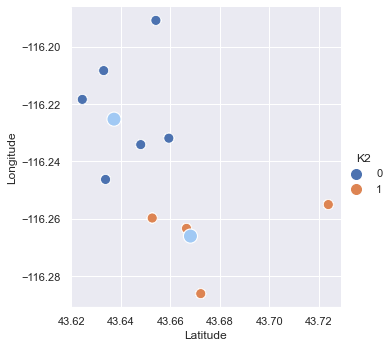

In [168]:
pltr = sns.relplot(
    data=pd_dat,
    y="Longitude", x="Latitude", hue = 'K2',
    size = 'K2',
    sizes = [100, 100]
)


# Add points
pltr2 = sns.scatterplot(
    data=K2_data,
    x = "Lat", y = "Long", hue = 'hue', 
    legend = False,
    size = 1,
    sizes = [200],
    palette="pastel")


## Plot for 3 Clusters:

In borth the K3 and K4 graphs, there is a cluster of a single point off on the right. The centroid of a singleton is obviously itself, so we've opened a business right in that persons house. 

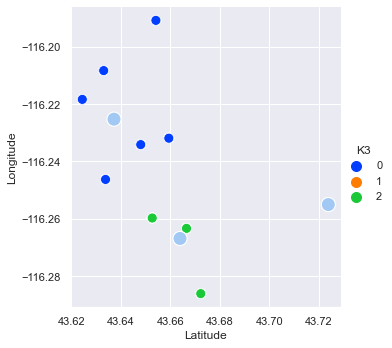

In [175]:
pltr = sns.relplot(
    data=pd_dat,
    y="Longitude", x="Latitude", hue = 'K3',
    size = 'K3',
    sizes = [100, 100, 100],
    palette = "bright"
)


# Add points
pltr2 = sns.scatterplot(
    data=K3_data,
    x = "Lat", y = "Long", hue = 'hue', 
    legend = False,
    size = 1,
    sizes = [200],
    palette="pastel")



## Plot for 4 Clusters:

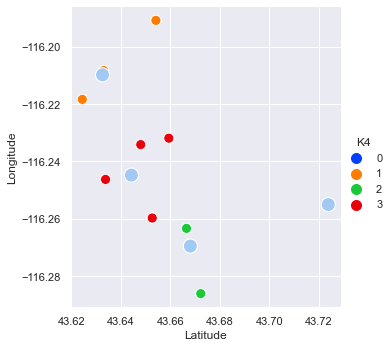

In [177]:
pltr = sns.relplot(
    data=pd_dat,
    y="Longitude", x="Latitude", hue = 'K4',
    size = 'K4',
    palette = "bright",
    sizes = [100, 100, 100, 100]
)


# Add points
pltr2 = sns.scatterplot(
    data=K4_data,
    x = "Lat", y = "Long", hue = 'hue', 
    legend = False,
    size = 1,
    sizes = [200],
    palette="pastel")

In [46]:
# Old code, unused

def get_vals(dat, col):
    ret = []
    for row in dat:
        ret.append(row[col])
    return ret

X = get_vals(data,0)
Y = get_vals(data,1)

## Examples of cluster visualization in 2D

Plotting original data:
    
<img src="clusters.png">

Plotting clusters with store locations
<img src="locations.png">

Copyright &copy; 2022 Marina Barsky. All rights reserved.